# Radiology paper figures

In [1]:
from IPython.display import Javascript

In [2]:
# %%js

# for (rule of document.styleSheets[0].cssRules){
#   if (rule.selectorText=='body') break
# }
# rule.style.fontSize = '200px'
# // alert(rule.style.fontSize)
# element.innerHTML = "Hello"

In [3]:
# def increase_font():
#   from IPython.display import Javascript
#   display(Javascript('''
#   for (rule of document.styleSheets[0].cssRules){
#     if (rule.selectorText=='body') {
#       rule.style.fontSize = '30px'
#       break
#     }
#   }
#   '''))

In [4]:
# # set it to run in every cell
# get_ipython().events.register('pre_run_cell', increase_font)
# # disable
# # get_ipython().events.unregister('pre_run_cell', increase_font)

# Imports

In [5]:
import plotly.graph_objects as go
import plotly.express as px
import colorcet as cc
import os
import plotly.io as pio
import pandas as pd
from google.cloud import bigquery
import numpy as np
import datetime
import seaborn as sns
import colorcet as cc

from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.colors import RGB
from bokeh.transform import jitter

from bokeh.models import HoverTool, PanTool, WheelZoomTool, BoxZoomTool, ResetTool, TapTool
from bokeh.models import Legend, LegendItem

from bokeh.palettes import brewer

from bokeh.layouts import row

from bokeh.io import export_png
from bokeh.io.export import get_screenshot_as_png

output_notebook()

# Custom functions

In [6]:
def calculate_time_index(row, df_input, studyDateColName="StudyDate"): #assumes only two studies per PatientID
  other_study_time = df_input[(df_input["PatientID"] == row["PatientID"])
    & (df_input["StudyInstanceUID"] != row["StudyInstanceUID"])][studyDateColName].values[0]
  if row[studyDateColName] < other_study_time:
    return "T0"
  elif row[studyDateColName] > other_study_time:
    return "T1"
  else:
    return "T"

# Import BigQuery evaluation results into dfs and combine with DICOM metdata/radiomics

In [7]:
#collections
prostatex_name = "ProstateX(n=345)"
qin_prost_rep_name = "QIN-PROST-REP(n=30)"
mri_us_biopsy_name = "MRI-US-BIOPSY(n=1017)"

### Import ProstateX segmentation results of SOTA methods

#### Method 1 --- nnUNet whole prostate

In [8]:
!wget -O prostatex_model1_preds_eval.csv https://raw.githubusercontent.com/ccosmin97/idc-prostate-mri-analysis/main/prostate_segmentation_notebooks/model1/results_csv/prostatex_model1_preds_eval.csv
prostatex_method1_df = pd.read_csv("prostatex_model1_preds_eval.csv")

--2023-06-28 03:59:12--  https://raw.githubusercontent.com/ccosmin97/idc-prostate-mri-analysis/main/prostate_segmentation_notebooks/model1/results_csv/prostatex_model1_preds_eval.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7605 (7.4K) [text/plain]
Saving to: ‘prostatex_model1_preds_eval.csv’

prostatex_model1_pr 100%[===================>]   7.43K  --.-KB/s    in 0s      

2023-06-28 03:59:13 (76.0 MB/s) - ‘prostatex_model1_preds_eval.csv’ saved [7605/7605]



In [9]:
prostatex_method1_df["collection"] = prostatex_method1_df.apply(lambda x : prostatex_name, axis=1)
prostatex_method1_df["method"] = prostatex_method1_df.apply(lambda x : "method1-nnUNet-whole prostate segmentation" ,axis=1)
prostatex_method1_df = prostatex_method1_df[['RefSerieUID', 'collection', 'method', 'dice_score', 'hsdff', 'hsdff_95', 'asd', 'regions']]
prostatex_method1_df = prostatex_method1_df.reset_index(drop=True)

dcm metadata

In [10]:
!wget -O prostatex_model1_dcm_metadata.csv https://raw.githubusercontent.com/ccosmin97/idc-prostate-mri-analysis/main/prostate_segmentation_notebooks/model1/results_csv/prostatex_model1_dcm_metadata.csv
prostatex_method1_dcm_df = pd.read_csv("prostatex_model1_dcm_metadata.csv")

--2023-06-28 03:59:13--  https://raw.githubusercontent.com/ccosmin97/idc-prostate-mri-analysis/main/prostate_segmentation_notebooks/model1/results_csv/prostatex_model1_dcm_metadata.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10949 (11K) [text/plain]
Saving to: ‘prostatex_model1_dcm_metadata.csv’

prostatex_model1_dc 100%[===================>]  10.69K  --.-KB/s    in 0s      

2023-06-28 03:59:13 (89.7 MB/s) - ‘prostatex_model1_dcm_metadata.csv’ saved [10949/10949]



In [11]:
prostatex_method1_dcm_df = prostatex_method1_dcm_df[['RefSerieUID',
                                                           "StudyDate", "StudyTime",
                                                           "PatientID", "StudyInstanceUID"]]

In [12]:
prostatex_method1_df = prostatex_method1_df.merge(prostatex_method1_dcm_df, on='RefSerieUID', how='left')
prostatex_method1_df = prostatex_method1_df.reset_index(drop=True)
prostatex_method1_df = prostatex_method1_df.sort_values(by=['PatientID'],
                                                                  ascending=True)

### Import QIN-Prostate-Repeatability segmentation results of SOTA methods

#### Method 1 --- nnUNet whole prostate

In [13]:
!wget -O qin_model1_preds_prostate_eval.csv https://raw.githubusercontent.com/ccosmin97/idc-prostate-mri-analysis/main/prostate_segmentation_notebooks/model1/results_csv/qin_model1_preds_prostate_eval.csv
qin_prost_rep_method1_df = pd.read_csv("qin_model1_preds_prostate_eval.csv")

--2023-06-28 03:59:13--  https://raw.githubusercontent.com/ccosmin97/idc-prostate-mri-analysis/main/prostate_segmentation_notebooks/model1/results_csv/qin_model1_preds_prostate_eval.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4325 (4.2K) [text/plain]
Saving to: ‘qin_model1_preds_prostate_eval.csv’

qin_model1_preds_pr 100%[===================>]   4.22K  --.-KB/s    in 0s      

2023-06-28 03:59:13 (42.6 MB/s) - ‘qin_model1_preds_prostate_eval.csv’ saved [4325/4325]



In [14]:
qin_prost_rep_method1_df["collection"] = qin_prost_rep_method1_df.apply(lambda x : qin_prost_rep_name ,axis=1)
qin_prost_rep_method1_df["method"] = qin_prost_rep_method1_df.apply(lambda x : "method1-nnUNet-whole prostate segmentation" ,axis=1)
qin_prost_rep_method1_df = qin_prost_rep_method1_df[['RefSerieUID', 'collection', 'method', 'dice_score', 'hsdff', 'hsdff_95', 'asd', 'regions']]
qin_prost_rep_method1_df = qin_prost_rep_method1_df.reset_index(drop=True)

In [15]:
!wget -O qin_model1_dcm_metadata.csv https://raw.githubusercontent.com/ccosmin97/idc-prostate-mri-analysis/main/prostate_segmentation_notebooks/model1/results_csv/qin_model1_dcm_metadata.csv
qin_prost_rep_method1_dcm_df = pd.read_csv("qin_model1_dcm_metadata.csv")

--2023-06-28 03:59:13--  https://raw.githubusercontent.com/ccosmin97/idc-prostate-mri-analysis/main/prostate_segmentation_notebooks/model1/results_csv/qin_model1_dcm_metadata.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5009 (4.9K) [text/plain]
Saving to: ‘qin_model1_dcm_metadata.csv’

qin_model1_dcm_meta 100%[===================>]   4.89K  --.-KB/s    in 0s      

2023-06-28 03:59:14 (48.7 MB/s) - ‘qin_model1_dcm_metadata.csv’ saved [5009/5009]



In [16]:
qin_prost_rep_method1_dcm_df = qin_prost_rep_method1_dcm_df[['RefSerieUID',
                                                           "StudyDate", "StudyTime",
                                                           "PatientID", "StudyInstanceUID"]]

In [17]:
qin_prost_rep_method1_df = qin_prost_rep_method1_df.merge(qin_prost_rep_method1_dcm_df, on='RefSerieUID', how='left')
qin_prost_rep_method1_df = qin_prost_rep_method1_df.reset_index(drop=True)
qin_prost_rep_method1_df = qin_prost_rep_method1_df.sort_values(by=['PatientID'],
                                                                  ascending=True)

### Import MRI-US-BIOPSY segmentation results of SOTA methods

#### Method 1 -- nnUNet whole prostate

In [18]:
!wget -O mri_us_biopsy_evaluation_nnunet_prostate.csv https://raw.githubusercontent.com/ccosmin97/idc-prostate-mri-analysis/main/prostate_segmentation_notebooks/model1/results_csv/mri_us_biopsy_evaluation_nnunet_prostate.csv
mri_us_biopsy_method1_prostate_df = pd.read_csv("mri_us_biopsy_evaluation_nnunet_prostate.csv")

--2023-06-28 03:59:14--  https://raw.githubusercontent.com/ccosmin97/idc-prostate-mri-analysis/main/prostate_segmentation_notebooks/model1/results_csv/mri_us_biopsy_evaluation_nnunet_prostate.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110446 (108K) [text/plain]
Saving to: ‘mri_us_biopsy_evaluation_nnunet_prostate.csv’

mri_us_biopsy_evalu 100%[===================>] 107.86K  --.-KB/s    in 0.009s  

2023-06-28 03:59:14 (11.9 MB/s) - ‘mri_us_biopsy_evaluation_nnunet_prostate.csv’ saved [110446/110446]



In [19]:
mri_us_biopsy_method1_prostate_df["collection"] = mri_us_biopsy_method1_prostate_df.apply(lambda x : mri_us_biopsy_name ,axis=1)
mri_us_biopsy_method1_prostate_df["method"] = mri_us_biopsy_method1_prostate_df.apply(lambda x : "method1-nnUNet-whole prostate segmentation" ,axis=1)
mri_us_biopsy_method1_prostate_df["regions"] = mri_us_biopsy_method1_prostate_df.apply(lambda x : "Prostate" ,axis=1)
mri_us_biopsy_method1_prostate_df = mri_us_biopsy_method1_prostate_df[['RefSerieUID', 'collection', 'method', 'dice_score', 'hsdff', 'hsdff_95', 'asd', 'regions']]
mri_us_biopsy_method1_prostate_df = mri_us_biopsy_method1_prostate_df.reset_index(drop=True)

In [20]:
!wget -O mri_us_biopsy_model1_dcm_metadata.csv https://raw.githubusercontent.com/ccosmin97/idc-prostate-mri-analysis/main/prostate_segmentation_notebooks/model1/results_csv/mri_us_biopsy_model1_dcm_metadata.csv
mri_us_biopsy_method1_dcm_df = pd.read_csv("mri_us_biopsy_model1_dcm_metadata.csv")

--2023-06-28 03:59:14--  https://raw.githubusercontent.com/ccosmin97/idc-prostate-mri-analysis/main/prostate_segmentation_notebooks/model1/results_csv/mri_us_biopsy_model1_dcm_metadata.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178421 (174K) [text/plain]
Saving to: ‘mri_us_biopsy_model1_dcm_metadata.csv’

mri_us_biopsy_model 100%[===================>] 174.24K  --.-KB/s    in 0.009s  

2023-06-28 03:59:14 (19.8 MB/s) - ‘mri_us_biopsy_model1_dcm_metadata.csv’ saved [178421/178421]



In [21]:
mri_us_biopsy_method1_dcm_df = mri_us_biopsy_method1_dcm_df[['RefSerieUID',
                                                           "StudyDate", "StudyTime",
                                                           "PatientID", "StudyInstanceUID"]]

In [22]:
mri_us_biopsy_method1_prostate_df = mri_us_biopsy_method1_prostate_df.merge(mri_us_biopsy_method1_dcm_df, on='RefSerieUID', how='left')
mri_us_biopsy_method1_prostate_df = mri_us_biopsy_method1_prostate_df.reset_index(drop=True)
mri_us_biopsy_method1_prostate_df = mri_us_biopsy_method1_prostate_df.sort_values(by=['PatientID'],
                                                                  ascending=True)

## Combine dfs

In [23]:
df_all = pd.concat([prostatex_method1_df,
                    qin_prost_rep_method1_df,
                    mri_us_biopsy_method1_prostate_df])

## Repeatability imports and combinations

### Import radiomics features and combine with dcm+quant seg eval resuls(dsc,hsdff,...)

Method 1 : nnUNet whole prostate region segmentation

In [24]:
!wget -O qin_model1_preds_prostate_radiomics.csv https://raw.githubusercontent.com/ccosmin97/idc-prostate-mri-analysis/main/prostate_segmentation_notebooks/model1/results_csv/qin_model1_preds_prostate_radiomics.csv
qin_prost_rep_method1_rad_df = pd.read_csv("qin_model1_preds_prostate_radiomics.csv")

--2023-06-28 03:59:14--  https://raw.githubusercontent.com/ccosmin97/idc-prostate-mri-analysis/main/prostate_segmentation_notebooks/model1/results_csv/qin_model1_preds_prostate_radiomics.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4849 (4.7K) [text/plain]
Saving to: ‘qin_model1_preds_prostate_radiomics.csv’

qin_model1_preds_pr 100%[===================>]   4.74K  --.-KB/s    in 0s      

2023-06-28 03:59:14 (65.5 MB/s) - ‘qin_model1_preds_prostate_radiomics.csv’ saved [4849/4849]



In [25]:
qin_prost_rep_method1_rad_df = qin_prost_rep_method1_rad_df[['RefSerieUID', "VoxelVolume",
                                                             "MeshVolume", "Sphericity"]]
qin_prost_rep_method1_combined_all_df = qin_prost_rep_method1_df.merge(qin_prost_rep_method1_rad_df, on='RefSerieUID', how='left')

qin_prost_rep_method1_combined_all_df['time_index'] = qin_prost_rep_method1_combined_all_df.apply(calculate_time_index,
                                    args = (qin_prost_rep_method1_combined_all_df, "StudyDate", ), axis=1)
qin_prost_rep_method1_combined_all_df["PID"] = qin_prost_rep_method1_combined_all_df.apply(lambda x: "PID_"\
                                                               +x["PatientID"].split('-')[1]\
                             +"_"+x["time_index"], axis=1)
qin_prost_rep_method1_combined_all_df = qin_prost_rep_method1_combined_all_df.sort_values(by=['PID'], ascending=True)
qin_prost_rep_method1_combined_all_df = qin_prost_rep_method1_combined_all_df.reset_index(drop=True)

In [26]:
!wget -O qin_prost_rep_idc_rad.csv https://raw.githubusercontent.com/ccosmin97/idc-prostate-mri-analysis/main/prostate_segmentation_notebooks/model1/results_csv/qin_prost_rep_idc_rad.csv
qin_prost_rep_idc_rad_df = pd.read_csv("qin_prost_rep_idc_rad.csv")

--2023-06-28 03:59:14--  https://raw.githubusercontent.com/ccosmin97/idc-prostate-mri-analysis/main/prostate_segmentation_notebooks/model1/results_csv/qin_prost_rep_idc_rad.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15116 (15K) [text/plain]
Saving to: ‘qin_prost_rep_idc_rad.csv’

qin_prost_rep_idc_r 100%[===================>]  14.76K  --.-KB/s    in 0s      

2023-06-28 03:59:15 (83.7 MB/s) - ‘qin_prost_rep_idc_rad.csv’ saved [15116/15116]



### Get IDC radiomics measurements for qin prostate repeatability collection

In [27]:
qin_prost_rep_idc_rad_df['time_index'] = qin_prost_rep_idc_rad_df.apply(calculate_time_index,
                                    args = (qin_prost_rep_idc_rad_df, "StudyDate", ), axis=1)
qin_prost_rep_idc_rad_df["PID"] = qin_prost_rep_idc_rad_df.apply(lambda x: "PID_"\
                                                               +x["PatientID"].split('-')[1]\
                             +"_"+x["time_index"], axis=1)

# Figures

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
import glob
import numpy as np

In [29]:
fig1_df = df_all.copy()
fig1_df['method'] = ['-'.join(x.split("\n")) for x in  fig1_df['method']]
my_pal = sns.color_palette(cc.glasbey, n_colors=len(fig1_df.method.unique()))
sns.set_style("whitegrid")
sns.set_context("notebook")

## **Figure 2 : Evaluation results on NCI IDC public collections grouped by SOTA methods**

In [30]:
fig2_df = df_all.copy()
fig2_df['method'] = ['\n'.join(x.split("-")) for x in  fig2_df['method']]
my_pal = sns.color_palette(cc.glasbey, n_colors=len(fig2_df.collection.unique()))
sns.set_style("whitegrid")
sns.set_context("notebook")

In [31]:
fig2_grid_prostate_df = pd.concat([prostatex_method1_df,#])
                                  #  , prostatex_method2_prostate_df, prostatex_method3_prostate_df,
                    qin_prost_rep_method1_df,# qin_prost_rep_method2_prostate_df, qin_prost_rep_method3_prostate_df,
                    mri_us_biopsy_method1_prostate_df])#, mri_us_biopsy_method3_prostate_df])
fig2_grid_prostate_df['method'] = ['\n'.join(x.split("-")[0:2]) for x in  fig2_grid_prostate_df['method']]
fig2_grid_prostate_df["collection"] = fig2_grid_prostate_df["collection"].apply(lambda x : "ProstateX(n=66)" if 'ProstateX' in x else x)
fig2_grid_prostate_df["collection"] = ['\n'.join(x.split("(")[0:1]) for x in  fig2_grid_prostate_df['collection']]
fig2_grid_prostate_df["collection"] = ["QIN-Prostate-Repeatability" if "QIN" in x else x for x in  fig2_grid_prostate_df['collection']]
fig2_grid_prostate_df = fig2_grid_prostate_df.rename(columns={"dice_score": "Dice Similarity Coefficient", "collection" : "Collection"}, errors="raise")
# fig2_grid_prostate_df.rename(columns={"ProstateX(n=345)": "ProstateX(n=66)"}, errors="raise")
my_pal = sns.color_palette(cc.glasbey, n_colors=len(fig2_grid_prostate_df.Collection.unique()))
sns.set_style("whitegrid")
sns.set_context("poster")

In [32]:
fig2_grid_prostate_df.columns

Index(['RefSerieUID', 'Collection', 'method', 'Dice Similarity Coefficient',
       'hsdff', 'hsdff_95', 'asd', 'regions', 'StudyDate', 'StudyTime',
       'PatientID', 'StudyInstanceUID'],
      dtype='object')

<IPython.core.display.Javascript object>

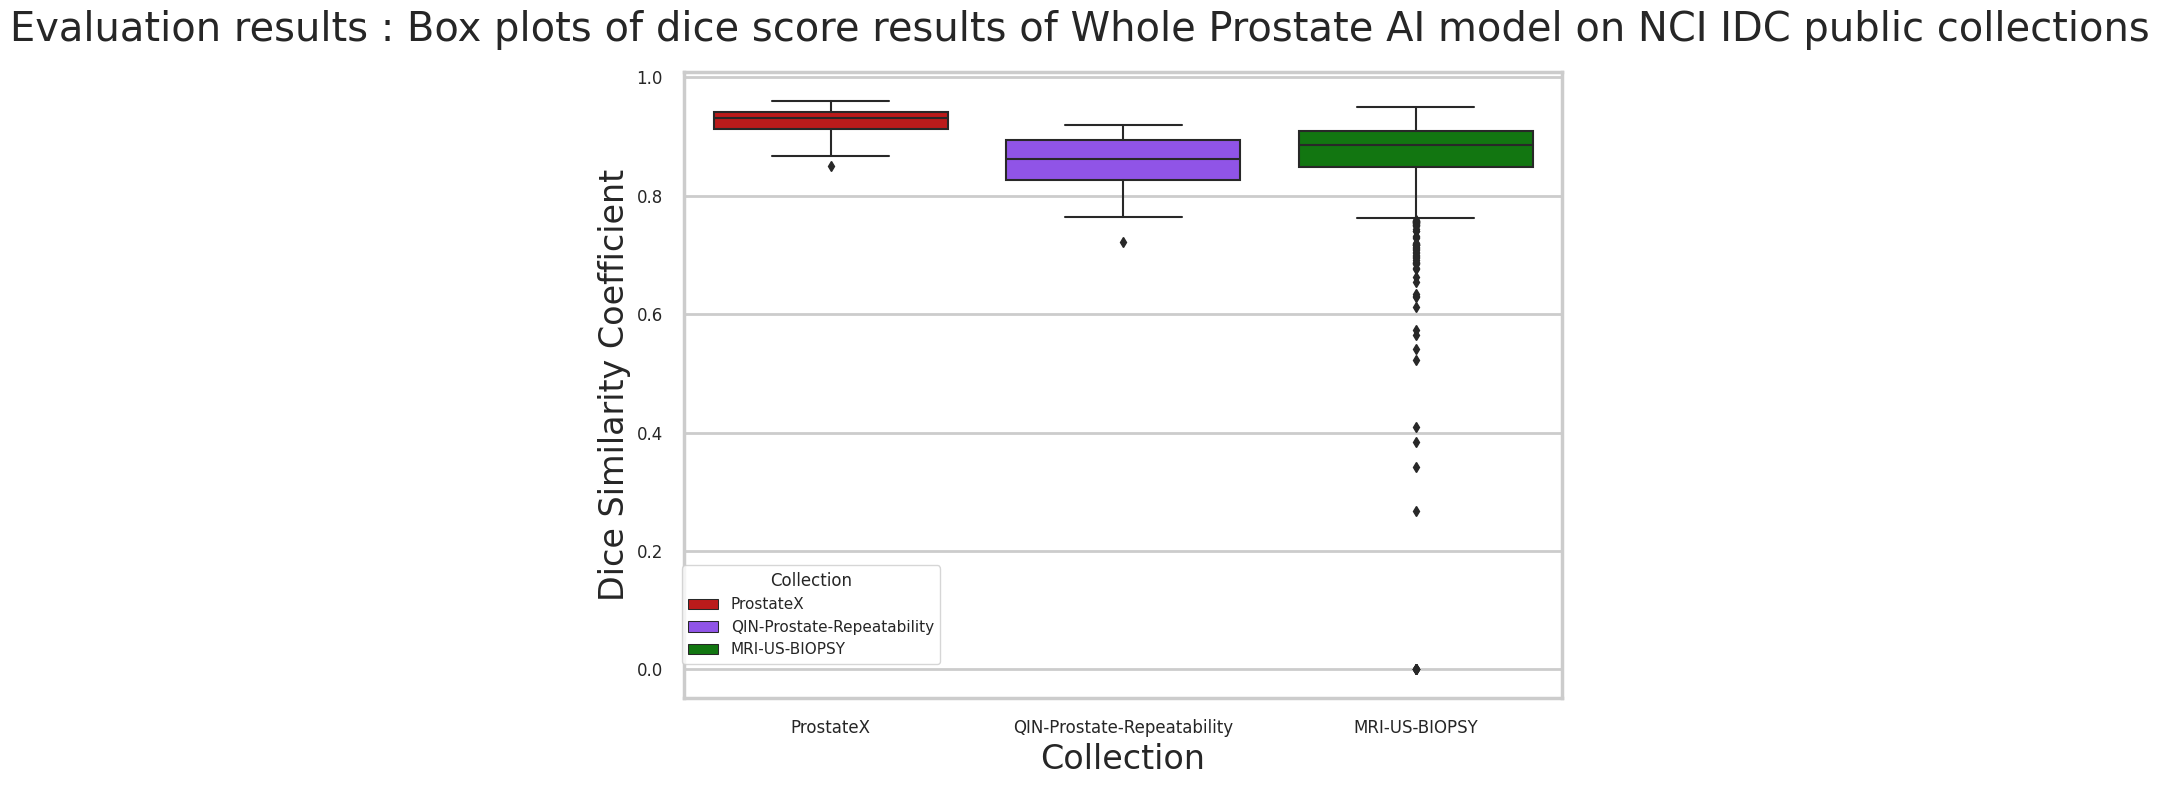

In [33]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 40000})'''))
fig, axes = plt.subplots(1, 1, figsize=(10, 8))
fig.suptitle('Evaluation results : Box plots of dice score results of Whole Prostate AI model on NCI IDC public collections')
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1)
# plt.rcParams.update({'font.size': 2})
# Dice Score
dsc_plot = sns.boxplot(#ax=axes[0, 0],
                       x="Collection", y="Dice Similarity Coefficient",
            hue="Collection", palette=my_pal,
            data=fig2_grid_prostate_df, dodge=False)#.set(title='Dice score')
#place legend outside top right corner of plot
sns.move_legend(dsc_plot, "upper right", bbox_to_anchor=(0.3, 0.224))# Average surface distance
dsc_plot.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

## **Figure 1 : QIN-Prostate-Repeatability : Comparison of prostate zones VoxelVolume for AI segmentations and ground-truth delineations between repeated examinations**

### Whole prostate -- model1 figure

In [34]:
# scatter plot using plotly
pio.templates["custom_nnUNet"] = go.layout.Template(layout=go.Layout(colorway=['#8b0000']))
pio.templates.default = 'custom_nnUNet'
temp_df = qin_prost_rep_method1_combined_all_df.sort_values(by="PID").copy()
temp_df["PID"] = temp_df["PID"].apply(lambda x : "_".join(x.split("_")[1:]))
x_ticks_formatted = list(temp_df["PID"].apply(lambda x : "        "+x.split("_")[0][-2:]).values)
x_ticks_formatted = [x if idx % 2 == 0 else "" for idx, x in enumerate(x_ticks_formatted)]
temp_df["VoxelVolume"] = temp_df.VoxelVolume.apply(lambda x : x/1000)#convert to mL
# temp_df['PID'] = ['\n'.join(x.split("_")) for x in  temp_df['PID']]
fig_ai = px.line(temp_df,
             x = "PID",
             y="VoxelVolume",
             color="PatientID",
             hover_data=["PatientID", "time_index", "StudyInstanceUID", "StudyDate", "StudyTime"],
              markers=True,
              width=1100, height=400)
# initializing showlegend to "False"
fig_ai.update_layout(showlegend=True, font=dict(size=10), legend_title="",
                     legend=dict(
                      font=dict(size= 9)))
fig_ai.update_xaxes(tickangle=0, ticktext=x_ticks_formatted,
                        tickvals=list(temp_df["PID"].values))
fig_ai.update_traces(showlegend=True)
for idx, trace in enumerate(fig_ai['data']):
  # if idx % 2 == 0 :
  trace["name"] = "AI"
  # else:
    # trace["name"] = "AI segmentations"
# set showlegend property by name of trace
for idx, trace in enumerate(fig_ai['data']):
    if idx > 0: trace['showlegend'] = False

fig_ai.show()

### QIN whole prostate expert figure

In [35]:
# scatter plot using plotly
#00FF0
pio.templates["custom_gt_idc"] = go.layout.Template(layout=go.Layout(colorway=['#00008b']))
pio.templates.default = 'custom_gt_idc'
temp_df = qin_prost_rep_idc_rad_df[qin_prost_rep_idc_rad_df["trackingIdentifier"] == 'WholeGland measurements'].sort_values(by="PID")
temp_df["PID"] = temp_df["PID"].apply(lambda x : "_".join(x.split("_")[1:]))
x_ticks_formatted = list(temp_df["PID"].apply(lambda x : "        "+x.split("_")[0][-2:]).values)
x_ticks_formatted = [x if idx % 2 == 0 else "" for idx, x in enumerate(x_ticks_formatted)]
temp_df["VoxelVolume"] = temp_df.VoxelVolume.apply(lambda x : x/1000)#convert to mL
fig_gt_idc = px.line(temp_df,
             x = "PID",
             y="VoxelVolume",
            #  points="all",
             color="PatientID",
             hover_data=["PatientID", "time_index", "StudyInstanceUID", "StudyDate", "StudyTime"],
              markers=True,
              width=1100, height=400)

# initializing showlegend to "False"
fig_gt_idc.update_layout(showlegend=True, font=dict(size=12))
fig_gt_idc.update_layout(showlegend=True, font=dict(size=10), legend_title="",
                     legend=dict(
                      font=dict(size= 9)))
fig_gt_idc.update_xaxes(tickangle=0, ticktext=x_ticks_formatted,
                        tickvals=list(temp_df["PID"].values))
for idx, trace in enumerate(fig_gt_idc['data']):
  # if idx % 2 == 0 :
  trace["name"] = "Expert"
  # else:
    # trace["name"] = "AI segmentations"
# set showlegend property by name of trace
for idx, trace in enumerate(fig_gt_idc['data']):
    if idx > 0: trace['showlegend'] = False
fig_gt_idc.show()

### Combined

In [36]:
#rename gt_cols
# merged_df_gt_idc.columns = 'idc_' + merged_df_gt_idc.columns.values
# merged_combined_df_idc = merged_df_nnuNet.merge(merged_df_gt_idc, left_on='PID', right_on='idc_PID', suffixes=(False, False))
#legend idc
fig = go.Figure(data = fig_gt_idc.data + fig_ai.data)
fig.update_layout(showlegend=True)
fig.update_xaxes(tickangle=0, ticktext=x_ticks_formatted,
                        tickvals=list(temp_df["PID"].values))
fig.update_layout(
                  width=1100, height=400,
                  title='QIN-Prostate-REPEATABILITY collection, repeatability study of volume between AI and expert whole prostate segmentations',
                  xaxis_title="CaseID",
                  yaxis_title="Volume, mL",
                  font=dict(size=10),
                  font_color="black")
fig.update_layout(margin=dict(l=80, r=80, t=80, b=80))
fig.update_layout(legend=dict(orientation = "v", yanchor="top",y=1,xanchor="right", x=1))
fig.show()
# fig.write_image("repeat_whole_prostate.png")